In [30]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from numpy.linalg import norm
from mpl_toolkits.mplot3d import Axes3D 

10, 28, 8/3, alpha = 1000

In [14]:
## Lorenz system parameters 
sigma = 10
rho = 28
beta = 8/3

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                    # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Control parameters
alpha = 1000
tau = 10

## Simulation parameters
T = 100
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)



## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

## Generate random intial state for reservoir with values between -0.5 to 0.5
r = 0.5 - 1.0 * np.random.rand(n)

## Inital state of Lorenz system, reservoir states and forcing function
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))


### Training using the pre-defined forcing functions ###

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = r

    fx = 10 * np.cos(0.05 * dt * t)
    fy = 10 * np.sin(0.05 * dt * t)
    
    f[0, t] = fx
    f[1, t] = fy

    xp = sigma * (y - x) + fx
    yp = x * (rho - z) - y + fy
    zp = x * y - beta * z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    r = np.tanh(A.dot(r) + Win.dot(u) + 1)

## Finding Wout matrix using ridge regression
Wout = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))




### Testing delayed control with altered rho ###

Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## The portion from here-on down should be repeated for different values of parameters

## Disturbance range is 0 - 10
## For each disturbance value, repeat the run 3 times and take average of 3

trials = 30     # 10 values, 3 trials for each
disturbance_range = np.arange(10)   # change in rho
avgdist = np.zeros(trials)
trial_counter = 0
r_init = r

for disturbance in disturbance_range:
    for attempt in np.arange(3):

        r = r_init
        gxnocontrol = np.zeros(ntest)
        gxcontrol = np.zeros(ntest)
        ux = np.zeros(ntest + 1)
        vx = np.zeros(ntest + 1)

        gynocontrol = np.zeros(ntest)
        gycontrol = np.zeros(ntest)
        uy = np.zeros(ntest + 1)
        vy = np.zeros(ntest + 1)

        gznocontrol = np.zeros(ntest)
        gzcontrol = np.zeros(ntest)
        uz = np.zeros(ntest + 1)
        vz = np.zeros(ntest + 1)

        ## Storing x, y, z time series data when there is disturbance and control is applied
        xcontrol = np.zeros(ntest)             
        ycontrol = np.zeros(ntest)
        zcontrol = np.zeros(ntest)

        ## Storing x, y, z time series data when there is disturbance and control is not applied
        xnocontrol = np.zeros(ntest)
        ynocontrol = np.zeros(ntest)
        znocontrol = np.zeros(ntest)

        ## Storing x, y, z time series data if there was no disturbance
        xpure = np.zeros(ntest)
        ypure = np.zeros(ntest)
        zpure = np.zeros(ntest)


        xxcontrol, yycontrol, zzcontrol = x, y, z
        xxnocontrol, yynocontrol, zznocontrol = x, y, z
        xxpure, yypure, zzpure = x, y, z



        for t in range(ntest):

            ## No disturbance and system is evolving with old parameters

            xxpurep = sigma * (yypure - xxpure)
            yypurep = xxpure * (rho - zzpure) - yypure
            zzpurep = xxpure * yypure - beta * zzpure

            xxpure += dt * xxpurep
            yypure += dt * yypurep
            zzpure += dt * zzpurep

            xpure[t] = xxpure
            ypure[t] = yypure
            zpure[t] = zzpure    
            
            

            ## Disturbance but no control
            
            gynocontrol[t] = 0


            xxnocontrolp = sigma * (yynocontrol - xxnocontrol)
            yynocontrolp = xxnocontrol * (rho - zznocontrol) - yynocontrol + gynocontrol[t]
            zznocontrolp = xxnocontrol * yynocontrol - beta * zznocontrol
            
            xxnocontrol += dt * xxnocontrolp
            yynocontrol += dt * yynocontrolp
            zznocontrol += dt * zznocontrolp

            xnocontrol[t] = xxnocontrol
            ynocontrol[t] = yynocontrol
            znocontrol[t] = zznocontrol



            ## Disturbance with delayed control

            gycontrol[t] = 0
            

            ux[t], uy[t], uz[t] = Wout.dot(r)

            vx[t + 1] = vx[t] + (dt / tau) * (ux[t] - vx[t])
            vy[t + 1] = vy[t] + (dt / tau) * (uy[t] - vy[t])
            vz[t + 1] = vz[t] + (dt / tau) * (uz[t] - vz[t])

            xxcontrolp = sigma * (yycontrol - xxcontrol) + gxcontrol[t] - alpha * vx[t]
            yycontrolp = xxcontrol * (rho - zzcontrol) - yycontrol + gycontrol[t] - alpha * vy[t]
            zzcontrolp = xxcontrol * yycontrol - beta * zzcontrol + gzcontrol[t] - alpha * vz[t]

            xxcontrol += dt * xxcontrolp
            yycontrol += dt * yycontrolp
            zzcontrol += dt * zzcontrolp

            xcontrol[t] = xxcontrol
            ycontrol[t] = yycontrol
            zcontrol[t] = zzcontrol

            r = np.tanh(A.dot(r) + Win.dot(np.array([xxcontrol, yycontrol, zzcontrol])) + 1)



        pwithout = np.vstack((xpure[-5000:], ypure[-5000:], zpure[-5000:]))
        pwith = np.vstack((xcontrol[-5000:], ycontrol[-5000:], zcontrol[-5000:]))
        sumdist = 0

        point_indices = np.random.randint(0, 5000 - 1, size = 100)

        for i in point_indices:
            mindist = norm(pwith[:, i] - pwithout[:, 0])
            for j in range(pwithout.shape[1]):
                if norm(pwith[:, i] - pwithout[:, j]) < mindist :
                    mindist = norm(pwith[:, i] - pwithout[:, j])
            sumdist += mindist

        avgdist[trial_counter] = (sumdist/100)
        trial_counter += 1





Disturbance is unchanged. So this is the average distance when parameter disturbance is 0.

In [16]:
np.mean(avgdist)

0.7236720480786751

In [33]:
## Lorenz system parameters 
sigma = 10
rho = 28
beta = 8/3

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                    # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Control parameters
alpha = 1000
tau = 10

## Simulation parameters
T = 100
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)



## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

## Generate random intial state for reservoir with values between -0.5 to 0.5
r = 0.5 - 1.0 * np.random.rand(n)

## Inital state of Lorenz system, reservoir states and forcing function
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))


### Training using the pre-defined forcing functions ###

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = r

    fx = 10 * np.cos(0.05 * dt * t)
    fy = 10 * np.sin(0.05 * dt * t)
    
    f[0, t] = fx
    f[1, t] = fy

    xp = sigma * (y - x) + fx
    yp = x * (rho - z) - y + fy
    zp = x * y - beta * z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    r = np.tanh(A.dot(r) + Win.dot(u) + 1)

## Finding Wout matrix using ridge regression
Wout = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))




### Testing delayed control with altered rho ###

Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## The portion from here-on down should be repeated for different values of parameters

## Disturbance range is 0 - 10
## For each disturbance value, repeat the run 3 times and take average of 3


disturbance_range = np.linspace(0, 20, 41)   # change in rho
numberofeach = 3
trials = numberofeach * disturbance_range.shape[0]
avgdist = np.zeros(trials)
trial_counter = 0
r_init = r
point_indices = np.random.randint(0, 5000 - 1, size = 100)

for disturbance in disturbance_range:
    for attempt in np.arange(numberofeach):

        r = r_init
        gxnocontrol = np.zeros(ntest)
        gxcontrol = np.zeros(ntest)
        ux = np.zeros(ntest + 1)
        vx = np.zeros(ntest + 1)

        gynocontrol = np.zeros(ntest)
        gycontrol = np.zeros(ntest)
        uy = np.zeros(ntest + 1)
        vy = np.zeros(ntest + 1)

        gznocontrol = np.zeros(ntest)
        gzcontrol = np.zeros(ntest)
        uz = np.zeros(ntest + 1)
        vz = np.zeros(ntest + 1)

        ## Storing x, y, z time series data when there is disturbance and control is applied
        xcontrol = np.zeros(ntest)             
        ycontrol = np.zeros(ntest)
        zcontrol = np.zeros(ntest)

        ## Storing x, y, z time series data when there is disturbance and control is not applied
        xnocontrol = np.zeros(ntest)
        ynocontrol = np.zeros(ntest)
        znocontrol = np.zeros(ntest)

        ## Storing x, y, z time series data if there was no disturbance
        xpure = np.zeros(ntest)
        ypure = np.zeros(ntest)
        zpure = np.zeros(ntest)


        xxcontrol, yycontrol, zzcontrol = x, y, z
        xxnocontrol, yynocontrol, zznocontrol = x, y, z
        xxpure, yypure, zzpure = x, y, z



        for t in range(ntest):

            ## No disturbance and system is evolving with old parameters

            xxpurep = sigma * (yypure - xxpure)
            yypurep = xxpure * (rho - zzpure) - yypure
            zzpurep = xxpure * yypure - beta * zzpure

            xxpure += dt * xxpurep
            yypure += dt * yypurep
            zzpure += dt * zzpurep

            xpure[t] = xxpure
            ypure[t] = yypure
            zpure[t] = zzpure    
            
            

            ## Disturbance but no control
            
            gynocontrol[t] = disturbance * xxnocontrol


            xxnocontrolp = sigma * (yynocontrol - xxnocontrol)
            yynocontrolp = xxnocontrol * (rho - zznocontrol) - yynocontrol + gynocontrol[t]
            zznocontrolp = xxnocontrol * yynocontrol - beta * zznocontrol
            
            xxnocontrol += dt * xxnocontrolp
            yynocontrol += dt * yynocontrolp
            zznocontrol += dt * zznocontrolp

            xnocontrol[t] = xxnocontrol
            ynocontrol[t] = yynocontrol
            znocontrol[t] = zznocontrol



            ## Disturbance with delayed control

            gycontrol[t] = disturbance * xxcontrol
            

            ux[t], uy[t], uz[t] = Wout.dot(r)

            vx[t + 1] = vx[t] + (dt / tau) * (ux[t] - vx[t])
            vy[t + 1] = vy[t] + (dt / tau) * (uy[t] - vy[t])
            vz[t + 1] = vz[t] + (dt / tau) * (uz[t] - vz[t])

            xxcontrolp = sigma * (yycontrol - xxcontrol) + gxcontrol[t] - alpha * vx[t]
            yycontrolp = xxcontrol * (rho - zzcontrol) - yycontrol + gycontrol[t] - alpha * vy[t]
            zzcontrolp = xxcontrol * yycontrol - beta * zzcontrol + gzcontrol[t] - alpha * vz[t]

            xxcontrol += dt * xxcontrolp
            yycontrol += dt * yycontrolp
            zzcontrol += dt * zzcontrolp

            xcontrol[t] = xxcontrol
            ycontrol[t] = yycontrol
            zcontrol[t] = zzcontrol

            r = np.tanh(A.dot(r) + Win.dot(np.array([xxcontrol, yycontrol, zzcontrol])) + 1)



        pwithout = np.vstack((xpure[-5000:], ypure[-5000:], zpure[-5000:]))
        pwith = np.vstack((xcontrol[-5000:], ycontrol[-5000:], zcontrol[-5000:]))
        sumdist = 0

        

        for i in point_indices:
            mindist = norm(pwith[:, i] - pwithout[:, 0])
            for j in range(pwithout.shape[1]):
                if norm(pwith[:, i] - pwithout[:, j]) < mindist :
                    mindist = norm(pwith[:, i] - pwithout[:, j])
            sumdist += mindist

        avgdist[trial_counter] = (sumdist/100)
        trial_counter += 1





In [20]:
avgdist.shape[0]

30

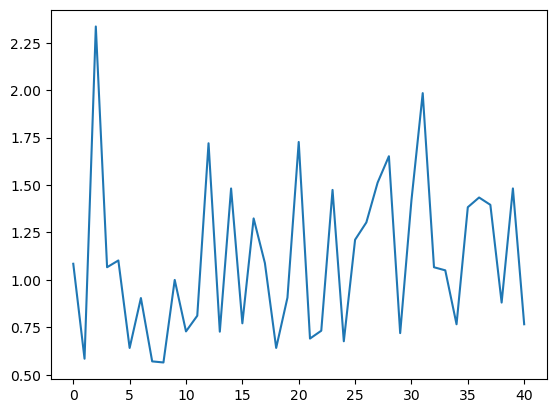

In [34]:
rows = np.zeros(avgdist.shape[0] // numberofeach)
for i in np.arange(avgdist.shape[0]):
    rows[i // numberofeach] += avgdist[i]

rows = rows / numberofeach

plt.plot(rows)

Comparing the distance between controlled and pure and uncontrolled and pure

In [ ]:
## Lorenz system parameters 
sigma = 10
rho = 28
beta = 2.667

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                    # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Control parameters
alpha = 1000
tau = 10

## Simulation parameters
T = 100
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)



## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

## Generate random intial state for reservoir with values between -0.5 to 0.5
r = 0.5 - 1.0 * np.random.rand(n)

## Inital state of Lorenz system, reservoir states and forcing function
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))


### Training using the pre-defined forcing functions ###

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = r

    fx = 10 * np.cos(0.05 * dt * t)
    fy = 10 * np.sin(0.05 * dt * t)
    
    f[0, t] = fx
    f[1, t] = fy

    xp = sigma * (y - x) + fx
    yp = x * (rho - z) - y + fy
    zp = x * y - beta * z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    r = np.tanh(A.dot(r) + Win.dot(u) + 1)

## Finding Wout matrix using ridge regression
Wout = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))




### Testing delayed control with altered rho ###

Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## The portion from here-on down should be repeated for different values of parameters

## Disturbance range is 0 - 10
## For each disturbance value, repeat the run 3 times and take average of 3


disturbance_range = np.linspace(0, 40, 81)   # change in rho
numberofeach = 3
trials = numberofeach * disturbance_range.shape[0]
avgdistcontrol = np.zeros(trials)
avgdistnocont = np.zeros(trials)
trial_counter = 0
r_init = r
point_indices = np.random.randint(0, 5000 - 1, size = 100)

for disturbance in disturbance_range:
    for attempt in np.arange(numberofeach):

        r = r_init
        gxnocontrol = np.zeros(ntest)
        gxcontrol = np.zeros(ntest)
        ux = np.zeros(ntest + 1)
        vx = np.zeros(ntest + 1)

        gynocontrol = np.zeros(ntest)
        gycontrol = np.zeros(ntest)
        uy = np.zeros(ntest + 1)
        vy = np.zeros(ntest + 1)

        gznocontrol = np.zeros(ntest)
        gzcontrol = np.zeros(ntest)
        uz = np.zeros(ntest + 1)
        vz = np.zeros(ntest + 1)

        ## Storing x, y, z time series data when there is disturbance and control is applied
        xcontrol = np.zeros(ntest)             
        ycontrol = np.zeros(ntest)
        zcontrol = np.zeros(ntest)

        ## Storing x, y, z time series data when there is disturbance and control is not applied
        xnocontrol = np.zeros(ntest)
        ynocontrol = np.zeros(ntest)
        znocontrol = np.zeros(ntest)

        ## Storing x, y, z time series data if there was no disturbance
        xpure = np.zeros(ntest)
        ypure = np.zeros(ntest)
        zpure = np.zeros(ntest)


        xxcontrol, yycontrol, zzcontrol = x, y, z
        xxnocontrol, yynocontrol, zznocontrol = x, y, z
        xxpure, yypure, zzpure = x, y, z



        for t in range(ntest):

            ## No disturbance and system is evolving with old parameters

            xxpurep = sigma * (yypure - xxpure)
            yypurep = xxpure * (rho - zzpure) - yypure
            zzpurep = xxpure * yypure - beta * zzpure

            xxpure += dt * xxpurep
            yypure += dt * yypurep
            zzpure += dt * zzpurep

            xpure[t] = xxpure
            ypure[t] = yypure
            zpure[t] = zzpure    
            
            

            ## Disturbance but no control
            
            gynocontrol[t] = disturbance * xxnocontrol


            xxnocontrolp = sigma * (yynocontrol - xxnocontrol)
            yynocontrolp = xxnocontrol * (rho - zznocontrol) - yynocontrol + gynocontrol[t]
            zznocontrolp = xxnocontrol * yynocontrol - beta * zznocontrol
            
            xxnocontrol += dt * xxnocontrolp
            yynocontrol += dt * yynocontrolp
            zznocontrol += dt * zznocontrolp

            xnocontrol[t] = xxnocontrol
            ynocontrol[t] = yynocontrol
            znocontrol[t] = zznocontrol



            ## Disturbance with delayed control

            gycontrol[t] = disturbance * xxcontrol
            

            ux[t], uy[t], uz[t] = Wout.dot(r)

            vx[t + 1] = vx[t] + (dt / tau) * (ux[t] - vx[t])
            vy[t + 1] = vy[t] + (dt / tau) * (uy[t] - vy[t])
            vz[t + 1] = vz[t] + (dt / tau) * (uz[t] - vz[t])

            xxcontrolp = sigma * (yycontrol - xxcontrol) + gxcontrol[t] - alpha * vx[t]
            yycontrolp = xxcontrol * (rho - zzcontrol) - yycontrol + gycontrol[t] - alpha * vy[t]
            zzcontrolp = xxcontrol * yycontrol - beta * zzcontrol + gzcontrol[t] - alpha * vz[t]

            xxcontrol += dt * xxcontrolp
            yycontrol += dt * yycontrolp
            zzcontrol += dt * zzcontrolp

            xcontrol[t] = xxcontrol
            ycontrol[t] = yycontrol
            zcontrol[t] = zzcontrol

            r = np.tanh(A.dot(r) + Win.dot(np.array([xxcontrol, yycontrol, zzcontrol])) + 1)



        pwithout = np.vstack((xpure[-5000:], ypure[-5000:], zpure[-5000:]))
        pwith = np.vstack((xcontrol[-5000:], ycontrol[-5000:], zcontrol[-5000:]))
        pdistnocont = np.vstack((xnocontrol[-5000:], ynocontrol[-5000:], znocontrol[-5000:]))
        
        sumdist = 0

        for i in point_indices:
            mindist = norm(pwith[:, i] - pwithout[:, 0])
            for j in range(pwithout.shape[1]):
                if norm(pwith[:, i] - pwithout[:, j]) < mindist :
                    mindist = norm(pwith[:, i] - pwithout[:, j])
            sumdist += mindist
        
        avgdistcontrol[trial_counter] = (sumdist/100)

        sumdist = 0

        for i in point_indices:
            mindist = norm(pdistnocont[:, i] - pwithout[:, 0])
            for j in range(pwithout.shape[1]):
                if norm(pdistnocont[:, i] - pwithout[:, j]) < mindist :
                    mindist = norm(pdistnocont[:, i] - pwithout[:, j])
            sumdist += mindist
        
        avgdistnocont[trial_counter] = (sumdist/100)




        trial_counter += 1


rowscontrol = np.zeros(avgdistcontrol.shape[0] // numberofeach)
for i in np.arange(avgdistcontrol.shape[0]):
    rowscontrol[i // numberofeach] += avgdistcontrol[i]

rowscontrol = rowscontrol / numberofeach

rowsnocontrol = np.zeros(avgdistnocont.shape[0] // numberofeach)
for i in np.arange(avgdistnocont.shape[0]):
    rowsnocontrol[i // numberofeach] += avgdistnocont[i]

rowsnocontrol = rowsnocontrol / numberofeach



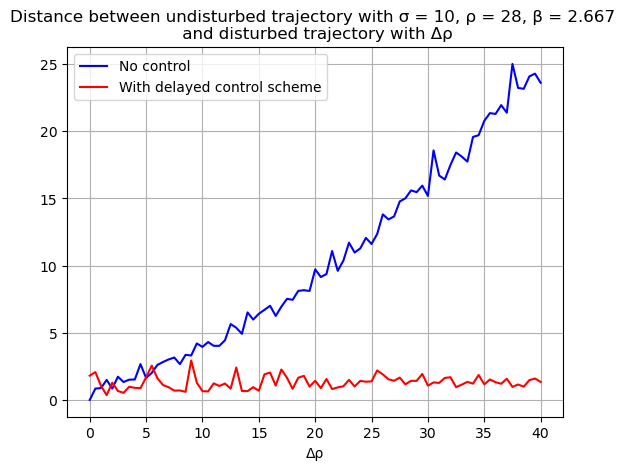

In [52]:
plt.figure()
plt.plot(disturbance_range, rowsnocontrol, 'b-', label = 'No control')
plt.plot(disturbance_range, rowscontrol, 'r-', label = 'With delayed control scheme')
plt.xlabel('\u0394\u03C1')
plt.legend()
plt.title(f"Distance between undisturbed trajectory with \u03C3 = {sigma}, \u03C1 = {rho}, \u03B2 = 2.667 \n and disturbed trajectory with \u0394\u03C1")
plt.grid()
plt.show()

Try for periodic orbits: 10, 150, 6 

In [53]:
## Lorenz system parameters 
sigma = 10
rho = 130
beta = 6

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                    # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Control parameters
alpha = 1000
tau = 10

## Simulation parameters
T = 100
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)



## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

## Generate random intial state for reservoir with values between -0.5 to 0.5
r = 0.5 - 1.0 * np.random.rand(n)

## Inital state of Lorenz system, reservoir states and forcing function
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))


### Training using the pre-defined forcing functions ###

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = r

    fx = 10 * np.cos(0.05 * dt * t)
    fy = 10 * np.sin(0.05 * dt * t)
    
    f[0, t] = fx
    f[1, t] = fy

    xp = sigma * (y - x) + fx
    yp = x * (rho - z) - y + fy
    zp = x * y - beta * z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    r = np.tanh(A.dot(r) + Win.dot(u) + 1)

## Finding Wout matrix using ridge regression
Wout = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))




### Testing delayed control with altered rho ###

Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## The portion from here-on down should be repeated for different values of parameters

## Disturbance range is 0 - 10
## For each disturbance value, repeat the run 3 times and take average of 3


disturbance_range = np.linspace(0, 40, 81)   # change in rho
numberofeach = 3
trials = numberofeach * disturbance_range.shape[0]
avgdistcontrol = np.zeros(trials)
avgdistnocont = np.zeros(trials)
trial_counter = 0
r_init = r
point_indices = np.random.randint(0, 5000 - 1, size = 100)

for disturbance in disturbance_range:
    for attempt in np.arange(numberofeach):

        r = r_init
        gxnocontrol = np.zeros(ntest)
        gxcontrol = np.zeros(ntest)
        ux = np.zeros(ntest + 1)
        vx = np.zeros(ntest + 1)

        gynocontrol = np.zeros(ntest)
        gycontrol = np.zeros(ntest)
        uy = np.zeros(ntest + 1)
        vy = np.zeros(ntest + 1)

        gznocontrol = np.zeros(ntest)
        gzcontrol = np.zeros(ntest)
        uz = np.zeros(ntest + 1)
        vz = np.zeros(ntest + 1)

        ## Storing x, y, z time series data when there is disturbance and control is applied
        xcontrol = np.zeros(ntest)             
        ycontrol = np.zeros(ntest)
        zcontrol = np.zeros(ntest)

        ## Storing x, y, z time series data when there is disturbance and control is not applied
        xnocontrol = np.zeros(ntest)
        ynocontrol = np.zeros(ntest)
        znocontrol = np.zeros(ntest)

        ## Storing x, y, z time series data if there was no disturbance
        xpure = np.zeros(ntest)
        ypure = np.zeros(ntest)
        zpure = np.zeros(ntest)


        xxcontrol, yycontrol, zzcontrol = x, y, z
        xxnocontrol, yynocontrol, zznocontrol = x, y, z
        xxpure, yypure, zzpure = x, y, z



        for t in range(ntest):

            ## No disturbance and system is evolving with old parameters

            xxpurep = sigma * (yypure - xxpure)
            yypurep = xxpure * (rho - zzpure) - yypure
            zzpurep = xxpure * yypure - beta * zzpure

            xxpure += dt * xxpurep
            yypure += dt * yypurep
            zzpure += dt * zzpurep

            xpure[t] = xxpure
            ypure[t] = yypure
            zpure[t] = zzpure    
            
            

            ## Disturbance but no control
            
            gynocontrol[t] = disturbance * xxnocontrol


            xxnocontrolp = sigma * (yynocontrol - xxnocontrol)
            yynocontrolp = xxnocontrol * (rho - zznocontrol) - yynocontrol + gynocontrol[t]
            zznocontrolp = xxnocontrol * yynocontrol - beta * zznocontrol
            
            xxnocontrol += dt * xxnocontrolp
            yynocontrol += dt * yynocontrolp
            zznocontrol += dt * zznocontrolp

            xnocontrol[t] = xxnocontrol
            ynocontrol[t] = yynocontrol
            znocontrol[t] = zznocontrol



            ## Disturbance with delayed control

            gycontrol[t] = disturbance * xxcontrol
            

            ux[t], uy[t], uz[t] = Wout.dot(r)

            vx[t + 1] = vx[t] + (dt / tau) * (ux[t] - vx[t])
            vy[t + 1] = vy[t] + (dt / tau) * (uy[t] - vy[t])
            vz[t + 1] = vz[t] + (dt / tau) * (uz[t] - vz[t])

            xxcontrolp = sigma * (yycontrol - xxcontrol) + gxcontrol[t] - alpha * vx[t]
            yycontrolp = xxcontrol * (rho - zzcontrol) - yycontrol + gycontrol[t] - alpha * vy[t]
            zzcontrolp = xxcontrol * yycontrol - beta * zzcontrol + gzcontrol[t] - alpha * vz[t]

            xxcontrol += dt * xxcontrolp
            yycontrol += dt * yycontrolp
            zzcontrol += dt * zzcontrolp

            xcontrol[t] = xxcontrol
            ycontrol[t] = yycontrol
            zcontrol[t] = zzcontrol

            r = np.tanh(A.dot(r) + Win.dot(np.array([xxcontrol, yycontrol, zzcontrol])) + 1)



        pwithout = np.vstack((xpure[-5000:], ypure[-5000:], zpure[-5000:]))
        pwith = np.vstack((xcontrol[-5000:], ycontrol[-5000:], zcontrol[-5000:]))
        pdistnocont = np.vstack((xnocontrol[-5000:], ynocontrol[-5000:], znocontrol[-5000:]))
        
        sumdist = 0

        for i in point_indices:
            mindist = norm(pwith[:, i] - pwithout[:, 0])
            for j in range(pwithout.shape[1]):
                if norm(pwith[:, i] - pwithout[:, j]) < mindist :
                    mindist = norm(pwith[:, i] - pwithout[:, j])
            sumdist += mindist
        
        avgdistcontrol[trial_counter] = (sumdist/100)

        sumdist = 0

        for i in point_indices:
            mindist = norm(pdistnocont[:, i] - pwithout[:, 0])
            for j in range(pwithout.shape[1]):
                if norm(pdistnocont[:, i] - pwithout[:, j]) < mindist :
                    mindist = norm(pdistnocont[:, i] - pwithout[:, j])
            sumdist += mindist
        
        avgdistnocont[trial_counter] = (sumdist/100)




        trial_counter += 1
        if trial_counter % 20 == 0:
            print(f"Progress:{trial_counter * 100.0 / trials}")


rowscontrol = np.zeros(avgdistcontrol.shape[0] // numberofeach)
for i in np.arange(avgdistcontrol.shape[0]):
    rowscontrol[i // numberofeach] += avgdistcontrol[i]

rowscontrol = rowscontrol / numberofeach

rowsnocontrol = np.zeros(avgdistnocont.shape[0] // numberofeach)
for i in np.arange(avgdistnocont.shape[0]):
    rowsnocontrol[i // numberofeach] += avgdistnocont[i]

rowsnocontrol = rowsnocontrol / numberofeach



In [60]:
trial_counter % 20

3

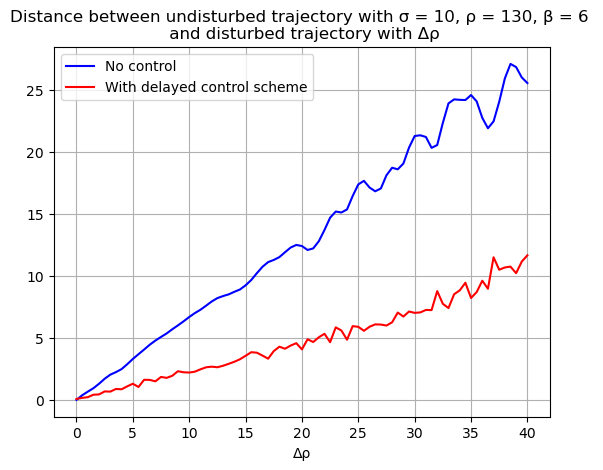

In [56]:
plt.figure()
plt.plot(disturbance_range, rowsnocontrol, 'b-', label = 'No control')
plt.plot(disturbance_range, rowscontrol, 'r-', label = 'With delayed control scheme')
plt.xlabel('\u0394\u03C1')
plt.legend()
plt.title(f"Distance between undisturbed trajectory with \u03C3 = {sigma}, \u03C1 = {rho}, \u03B2 = {beta} \n and disturbed trajectory with \u0394\u03C1")
plt.grid()
plt.show()

In [61]:
## Lorenz system parameters 
sigma = 10
rho = 130
beta = 4

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                    # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Control parameters
alpha = 1000
tau = 10

## Simulation parameters
T = 100
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)



## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

## Generate random intial state for reservoir with values between -0.5 to 0.5
r = 0.5 - 1.0 * np.random.rand(n)

## Inital state of Lorenz system, reservoir states and forcing function
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))


### Training using the pre-defined forcing functions ###

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = r

    fx = 10 * np.cos(0.05 * dt * t)
    fy = 10 * np.sin(0.05 * dt * t)
    
    f[0, t] = fx
    f[1, t] = fy

    xp = sigma * (y - x) + fx
    yp = x * (rho - z) - y + fy
    zp = x * y - beta * z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    r = np.tanh(A.dot(r) + Win.dot(u) + 1)

## Finding Wout matrix using ridge regression
Wout = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))




### Testing delayed control with altered rho ###

Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## The portion from here-on down should be repeated for different values of parameters

## Disturbance range is 0 - 20
## For each disturbance value, repeat the run 3 times and take average of 3


disturbance_range = np.linspace(0, 20, 41)   # change in rho
numberofeach = 3
trials = numberofeach * disturbance_range.shape[0]
avgdistcontrol = np.zeros(trials)
avgdistnocont = np.zeros(trials)
trial_counter = 0
r_init = r
point_indices = np.random.randint(0, 5000 - 1, size = 100)

for disturbance in disturbance_range:
    for attempt in np.arange(numberofeach):

        r = r_init
        gxnocontrol = np.zeros(ntest)
        gxcontrol = np.zeros(ntest)
        ux = np.zeros(ntest + 1)
        vx = np.zeros(ntest + 1)

        gynocontrol = np.zeros(ntest)
        gycontrol = np.zeros(ntest)
        uy = np.zeros(ntest + 1)
        vy = np.zeros(ntest + 1)

        gznocontrol = np.zeros(ntest)
        gzcontrol = np.zeros(ntest)
        uz = np.zeros(ntest + 1)
        vz = np.zeros(ntest + 1)

        ## Storing x, y, z time series data when there is disturbance and control is applied
        xcontrol = np.zeros(ntest)             
        ycontrol = np.zeros(ntest)
        zcontrol = np.zeros(ntest)

        ## Storing x, y, z time series data when there is disturbance and control is not applied
        xnocontrol = np.zeros(ntest)
        ynocontrol = np.zeros(ntest)
        znocontrol = np.zeros(ntest)

        ## Storing x, y, z time series data if there was no disturbance
        xpure = np.zeros(ntest)
        ypure = np.zeros(ntest)
        zpure = np.zeros(ntest)


        xxcontrol, yycontrol, zzcontrol = x, y, z
        xxnocontrol, yynocontrol, zznocontrol = x, y, z
        xxpure, yypure, zzpure = x, y, z



        for t in range(ntest):

            ## No disturbance and system is evolving with old parameters

            xxpurep = sigma * (yypure - xxpure)
            yypurep = xxpure * (rho - zzpure) - yypure
            zzpurep = xxpure * yypure - beta * zzpure

            xxpure += dt * xxpurep
            yypure += dt * yypurep
            zzpure += dt * zzpurep

            xpure[t] = xxpure
            ypure[t] = yypure
            zpure[t] = zzpure    
            
            

            ## Disturbance but no control
            
            gynocontrol[t] = disturbance * xxnocontrol


            xxnocontrolp = sigma * (yynocontrol - xxnocontrol)
            yynocontrolp = xxnocontrol * (rho - zznocontrol) - yynocontrol + gynocontrol[t]
            zznocontrolp = xxnocontrol * yynocontrol - beta * zznocontrol
            
            xxnocontrol += dt * xxnocontrolp
            yynocontrol += dt * yynocontrolp
            zznocontrol += dt * zznocontrolp

            xnocontrol[t] = xxnocontrol
            ynocontrol[t] = yynocontrol
            znocontrol[t] = zznocontrol



            ## Disturbance with delayed control

            gycontrol[t] = disturbance * xxcontrol
            

            ux[t], uy[t], uz[t] = Wout.dot(r)

            vx[t + 1] = vx[t] + (dt / tau) * (ux[t] - vx[t])
            vy[t + 1] = vy[t] + (dt / tau) * (uy[t] - vy[t])
            vz[t + 1] = vz[t] + (dt / tau) * (uz[t] - vz[t])

            xxcontrolp = sigma * (yycontrol - xxcontrol) + gxcontrol[t] - alpha * vx[t]
            yycontrolp = xxcontrol * (rho - zzcontrol) - yycontrol + gycontrol[t] - alpha * vy[t]
            zzcontrolp = xxcontrol * yycontrol - beta * zzcontrol + gzcontrol[t] - alpha * vz[t]

            xxcontrol += dt * xxcontrolp
            yycontrol += dt * yycontrolp
            zzcontrol += dt * zzcontrolp

            xcontrol[t] = xxcontrol
            ycontrol[t] = yycontrol
            zcontrol[t] = zzcontrol

            r = np.tanh(A.dot(r) + Win.dot(np.array([xxcontrol, yycontrol, zzcontrol])) + 1)



        pwithout = np.vstack((xpure[-5000:], ypure[-5000:], zpure[-5000:]))
        pwith = np.vstack((xcontrol[-5000:], ycontrol[-5000:], zcontrol[-5000:]))
        pdistnocont = np.vstack((xnocontrol[-5000:], ynocontrol[-5000:], znocontrol[-5000:]))
        
        sumdist = 0

        for i in point_indices:
            mindist = norm(pwith[:, i] - pwithout[:, 0])
            for j in range(pwithout.shape[1]):
                if norm(pwith[:, i] - pwithout[:, j]) < mindist :
                    mindist = norm(pwith[:, i] - pwithout[:, j])
            sumdist += mindist
        
        avgdistcontrol[trial_counter] = (sumdist/100)

        sumdist = 0

        for i in point_indices:
            mindist = norm(pdistnocont[:, i] - pwithout[:, 0])
            for j in range(pwithout.shape[1]):
                if norm(pdistnocont[:, i] - pwithout[:, j]) < mindist :
                    mindist = norm(pdistnocont[:, i] - pwithout[:, j])
            sumdist += mindist
        
        avgdistnocont[trial_counter] = (sumdist/100)




        trial_counter += 1
        if trial_counter % 20 == 0:
            print(f"\n Progress:{trial_counter * 100.0 / trials} %")


rowscontrol = np.zeros(avgdistcontrol.shape[0] // numberofeach)
for i in np.arange(avgdistcontrol.shape[0]):
    rowscontrol[i // numberofeach] += avgdistcontrol[i]

rowscontrol = rowscontrol / numberofeach

rowsnocontrol = np.zeros(avgdistnocont.shape[0] // numberofeach)
for i in np.arange(avgdistnocont.shape[0]):
    rowsnocontrol[i // numberofeach] += avgdistnocont[i]

rowsnocontrol = rowsnocontrol / numberofeach




 Progress:16.260162601626018

 Progress:32.520325203252035

 Progress:48.78048780487805

 Progress:65.04065040650407

 Progress:81.30081300813008

 Progress:97.5609756097561


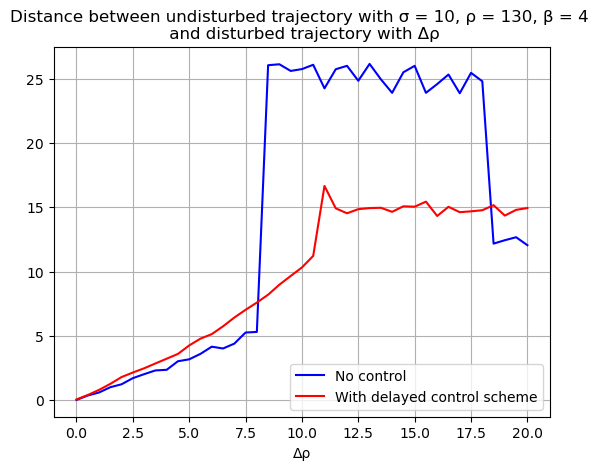

In [62]:
plt.figure()
plt.plot(disturbance_range, rowsnocontrol, 'b-', label = 'No control')
plt.plot(disturbance_range, rowscontrol, 'r-', label = 'With delayed control scheme')
plt.xlabel('\u0394\u03C1')
plt.legend()
plt.title(f"Distance between undisturbed trajectory with \u03C3 = {sigma}, \u03C1 = {rho}, \u03B2 = {beta} \n and disturbed trajectory with \u0394\u03C1")
plt.grid()
plt.show()